# NN以外のアルゴリズム

## 方針
1. 前処理などをせずに認識させてベンチマークを得る
2. 色々なアルゴリズムを試す
3. 前処理
4. 組み合わせ

## 参照サイト


- OpenCVとPythonで始める画像処理  
  http://postd.cc/image-processing-101/  
  
  
- 画像処理の数式を見て石になった時のための、金の針  
  http://qiita.com/icoxfog417/items/adbbf445d357c924b8fc


- 精度に関して  
  http://qiita.com/yu4u/items/dba4fc37d8c660e6cfba


- Liaro勉強会  
  https://github.com/Liaro/Liaro_ML_Learning

## 知見
- 多少画像が歪んでも，認識精度には影響がないため,画像の形状は揃えるべき． 
- PILのreshape, OpenCVのresizeは共に(横, 縦)で指定．
- zipは長さが短い方に合わせられてしまうのでzip_longestを使用．
- 現実世界のデータセットは基本的に偏りがあるため，「歩と言っておけばだいたい当たる現象」が起きた
- 精度といっても正確度なのか適合率なのかF値なのかで意味が変わるため，目的にあった精度を使う必要がある．
- **Confusion matrix**を出力
- n_jobsをPCのコア数に合わせて変えたほうがいい．デフォルトではシングルスレッドで実行してる．このmacは2
- グレースケール化する画像は3channel or 4channelの必要あり．1次元化した画像を渡してしまいはまった．

## モジュールのインポート

In [16]:
# load_data.ipynb にある関数 load_data() をモジュールとしてインポートするための記述
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
from load_data import load_data

import numpy as np
import cv2
import itertools
from PIL import Image
import matplotlib.pyplot as plt
# plt.style.use('dark_background') # jupyterの背景を黒くしている場合， 混同行列などの軸ラベルが見やすくなる．
% matplotlib inline

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## データセットの準備
- 駒の種類ごとに，train:test = 7:3 に分割
- 並び順はランダム

x_train: (38532, 80, 64, 3)
y_train: (38532,)
x_test: (16515, 80, 64, 3)
y_test: (16515,)


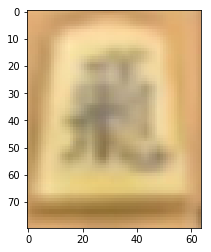

In [7]:
# データの読み込み
koma = load_data() # 駒の種類．混同行列に利用．
class_names = koma.target_names
x = koma.data #.reshape(koma.data.shape[0], -1) # 一次元化
y = koma.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# データ数、形状確認
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

# サンプルの表示 
x_sample = x_train[0]
plt.imshow(x_sample) 

## 前処理  


候補  

- グレースケール化 → 閾値処理
- ガウスぼかし
- etc.

	元画像


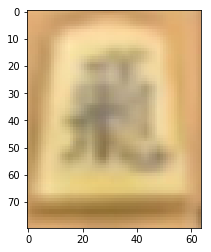


	グレースケール化後の画像


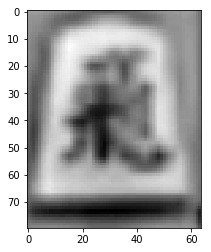


	閾値処理後の画像


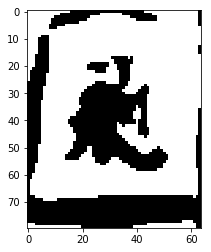

In [8]:
# グレースケール化→閾値処理のテスト
## 前処理前
sample_img = x_train[0]
print("\t元画像")
plt.imshow(sample_img)
plt.show()

## グレースケール化
gray_sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
print("\n\tグレースケール化後の画像")
plt.imshow(gray_sample_img, cmap="gray")
plt.show()

# # 閾値処理
_, threshold_sample_img = cv2.threshold(gray_sample_img, 170, 255, cv2.THRESH_BINARY)
print("\n\t閾値処理後の画像")
plt.imshow(threshold_sample_img, cmap="gray")
plt.show()

## 分類  


スコア(train, test, F1)

- RF：0.99, 0.98, 0.98

In [11]:
# NNを利用しないモデル
models = {
    "knn": KNeighborsClassifier(n_jobs=2), # 時間かかる
    "dt": DecisionTreeClassifier(), # 時間かかる
    "rf": RandomForestClassifier(n_jobs=-1), # すぐ終わる
    "svm": SVC() # 時間かかる
}

In [12]:
# 2値化を行う関数
def binarization(x_data):
    # グレースケール化
    x_data =  np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in x_data])

    # 閾値処理
    x_data = np.array([cv2.threshold(img, 170, 255, cv2.THRESH_BINARY)[1] for img in x_data])

    return x_data

In [13]:
# 混同行列を描画する関数
def plot_confusion_matrix(y_test, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #  混同行列の作成
    cm = confusion_matrix(y_test, y_pred)

    # 正規化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # 行の和を列ベクトル化

    plt.figure(figsize = (6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[ 0.85636463  0.97974569  0.98701063  0.98782703  0.96256587]


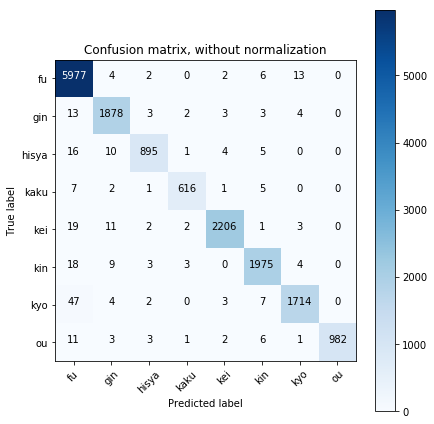

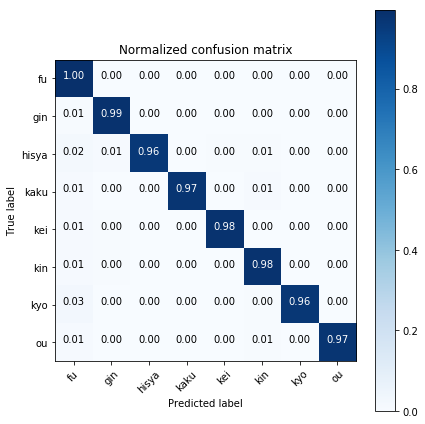

In [17]:
# データの読み込み
x = koma.data.reshape(koma.data.shape[0], -1) # 一次元化
y = koma.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


clf = models["rf"] # モデルの選択 

scores = cross_val_score(clf, x, y, cv=5)
print(scores)

clf = model.fit(x_train, y_train) # 学習
y_pred = clf.predict(x_test) # 予測

# print(model.__class__.__name__)
# print("train:", clf.score(x_train, y_train))
# print("test:", clf.score(x_test, y_test))
# print("F1: ", f1_score(y_test[:len(y_pred)], y_pred, average='macro'))

# 正規化前の混合行列の可視化
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')

# 正規化後の混合行列の可視化
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()